In [1]:
import numpy as np
import pandas
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import pickle
import matplotlib.pyplot as plt

## Constants

In [2]:
# file_path = "/nfs/lab/varpred/Final_Results/final_matrices/"
file_path = "./"
t1d_mat = file_path + "T1D_final_short.bed"
t2d_mat = file_path + "T2D_final_short.bed"
topmed_mat = file_path + "topmed_final.bed"
proba_threshold_high = 0.8
proba_threshold_low = 0.000005

# Data Ingestion

In [4]:
t1d_data = pandas.read_csv(t1d_mat, sep=' ')
# t2d_data = pandas.read_csv(t2d_mat, sep=' ')
# topmed_data = pandas.read_csv(topmed_mat, sep=' ')

t1d_labels = t1d_data["Probability"]
t1d_data = t1d_data.drop(['VarID', 'Probability'], axis=1)
# t2d_labels = t2d_data["Probability"]
# t2d_data = t2d_data.drop(['VarID', 'Probability'], axis=1)
# topmed_labels = topmed_data["Probability"]
# topmed_data = topmed_data.drop(['VarID', 'Probability'], axis=1)

In [4]:
# # Filtering out variants with all 0s - NOT NEEDED WITH SHORT BED FILES

# print('t1d')
# print(len(t1d_data) - len(t1d_data[(t1d_data.T != 0).any()]))
# print(len(t1d_data[(t1d_data.T != 0).any()]))

# # print('t2d')
# # print(len(t2d_data) - len(t2d_data[(t2d_data.T != 0).any()]))
# # print(len(t2d_data[(t2d_data.T != 0).any()]))

# # print('topmed')
# # vprint(len(topmed_data) - len(topmed_data[(topmed_data.T != 0).any()]))
# # print(len(topmed_data[(topmed_data.T != 0).any()]))

# t1d_peaks = t1d_data[(t1d_data.T != 0).any()]
# t1d_peak_labels = t1d_labels[t1d_labels.index.isin(t1d_peaks.index)]
# t1d_peaks = t1d_peaks.reset_index(drop=True)
# t1d_peak_labels = t1d_peak_labels.reset_index(drop=True)
# print("high", len(t1d_peak_labels[t1d_peak_labels > 0.01]))
# print("low", len(t1d_peak_labels[t1d_peak_labels < 0.000008]))
# print("unlabelled", len(t1d_peak_labels[(t1d_peak_labels <= 0.01) & (t1d_peak_labels >= 0.000005)]))
# proba_threshold_high = 0.01
# proba_threshold_low = 0.000005

# # t2d_peaks = t2d_data[(t2d_data.T != 0).any()]

In [6]:
# Categorical labelling
def label_prob(prob):
    if prob > proba_threshold_high:
        return 1
    elif prob < proba_threshold_low:
        return 0
    else:
        return -1

t1d_peak_labels = t1d_peak_labels.apply(lambda row: label_prob(row))

# Label Propagation

In [7]:
label_prop_model = LabelPropagation()
# label_prop_model.fit(data, labels)

In [ ]:
pickle.dump(label_prop_model, open(f"./models/label_prop_model_thresh_{proba_threshold}", 'wb'))

# Label Spreading

In [8]:
label_spread_model = LabelSpreading(alpha=(proba_threshold_high))
label_spread_knn = LabelSpreading(alpha=(1-proba_threshold_high), kernel="knn")
# label_spread_model.fit(data, labels)

In [26]:
pickle.dump(label_spread_model, open(f"./models/label_spread_model_thresh_{proba_threshold}", 'wb'))

# Experimenting

In [33]:
# known_data_bool = labels != -1
# all_data = data.copy(deep=True)
# all_data.insert(len(all_data.columns), 'label', labels)
# all_data.insert(len(all_data.columns), 'known', known_data_bool)
# all_known_data = all_data[all_data.known == True]
# all_unknown_data = all_data[all_data.known == False]
# known_data = all_known_data.drop(['label', 'known'], axis=1)
# known_labels = all_known_data['label']
# unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
# unknown_labels = all_unknown_data['label']

# known_data_bool = t1d_peak_labels != -1
# all_data = t1d_peaks.copy(deep=True)
# all_data.insert(len(all_data.columns), 'label', t1d_peak_labels)
# all_data.insert(len(all_data.columns), 'known', known_data_bool)
# all_known_data = all_data[all_data.known == True]
# all_unknown_data = all_data[all_data.known == False]
# known_data = all_known_data.drop(['label', 'known'], axis=1)
# known_labels = all_known_data['label']
# unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
# unknown_labels = all_unknown_data['label']

def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, known_data, known_labels, unknown_data, unknown_labels

all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(t1d_peaks, t1d_peak_labels)

In [34]:
print('Num unknown:', len(unknown_labels))
print('Num negative:', len(known_labels[known_labels == 0]))
print('Num positive:', len(known_labels[known_labels == 1]))

Num unknown: 4479
Num negative: 4661
Num positive: 4238


In [35]:
def create_splitter(all_known_data, unknown_data):
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter

create_splitter(all_known_data, unknown_data)

In [54]:
cv_score = cross_val_score(label_prop_model, t1d_peaks, y=t1d_peak_labels, cv=custom_splitter(splits), verbose=1, n_jobs=4)

<class 'generator'>
11089
1716 573
12805 573
1716 573
12805 573
1716 573
12805 573
1716 573
12805 573
1716 573
12805 573


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.0min finished


In [55]:
cv_score

array([0.09773124, 0.09773124, 0.11343805, 0.12914485, 0.10994764])

In [36]:
cv_score = cross_val_score(label_spread_knn, t1d_peaks, y=t1d_peak_labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=Conve

In [37]:
cv_score

array([0.38831461, 0.38876404, 0.36      , 0.36359551, 0.37168539])

# PCA

In [7]:
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1d_data)

,Acinar_peaks_bin,Alpha_peaks_bin,Beta_peaks_bin,Delta_peaks_bin,Ductal_peaks_bin,Endo_peaks_bin,Gamma_peaks_bin,Immune_peaks_bin,Stellate_peaks_bin,Acinar_peaks,...,DFF882BJI_peaks,DFF895EGE_peaks,DFF930SVS_peaks,DFF940AGF_peaks,DFF944QFG_peaks,DFF948XFT_peaks,DFF949QBB_peaks,DFF980GZN_peaks,PC1,PC2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-6759.338992,-10743.136265
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-6762.413044,-10737.861778
2,1,0,0,0,0,0,0,1,1,160,...,0,0,0,328,56,0,0,0,-6510.536888,-11208.013726
3,1,0,0,0,0,0,0,1,1,160,...,0,0,0,328,56,0,0,0,-6510.536888,-11208.013726
4,1,0,0,0,0,0,0,1,1,160,...,0,0,0,328,56,0,0,0,-6509.232637,-11210.591753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5543,1567,0,-8996.686341,-2333.834034
24131,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-10583.608219,243.039159
24132,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-10425.678486,331.768954
24133,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-10425.678486,331.768954


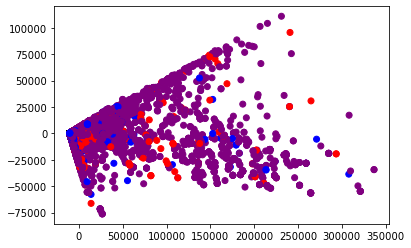

In [8]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, 0.01, 0.000007))

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
color_map = ['purple', 'red', 'blue']
colors = [color_map[t1d_labels_thresh[x] + 1] for x in range(len(t1d_labels_thresh.values))]
ax.scatter(new_data[:,0], new_data[:,1], color=colors)

# ax.set_xlabel("PC 1", size=15)
# ax.set_ylabel("PC 2", size=15)
# ax.set_xticklabels(ax.get_xticks(), size=12)
# ax.set_yticklabels(ax.get_yticks(), size=12)
# ax.spines["top"].set_visible(False);
# ax.spines["right"].set_visible(False);
# ax.get_xaxis().tick_bottom();
# ax.get_yaxis().tick_left();
t1d_PCS = t1d_data.copy(deep=True)
t1d_PCS.insert(len(t1d_data.columns), "PC1", new_data[:,0])
t1d_PCS.insert(len(t1d_PCS.columns), "PC2", new_data[:,1])
# t1d_PCS.sort_values('PC1', ascending=False)[:10].to_csv('Results/top_10_PC1_vals')
t1d_PCS[t1d_PCS.PC1 <= 100]

In [69]:
t1d_less_than_100 = t1d_PCS[t1d_PCS.PC1 <= 100]
t1d_less_than_100[t1d_less_than_100.PC1 >= 0].sort_values('PC1')[:10].to_csv('Results/top_10_PC1_vals.csv', mode='a')

In [75]:
pca.fit(t1d_data)
pandas.DataFrame(pca.components_,columns=t1d_data.columns,index = ['PC-1','PC-2']).to_csv('Results/PC_columns_correlation.csv')

0.8532546302044829


Text(0, 0.5, '% explained variance')

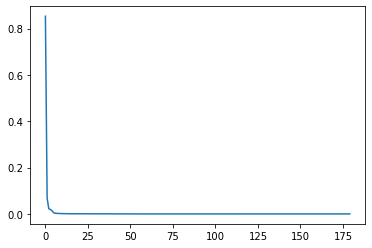

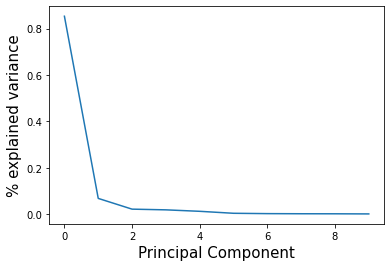

In [45]:
# my_model = PCA(n_components=0.99, svd_solver='full')
my_model = PCA()
my_model.fit_transform(t1d_data)
ratio = my_model.explained_variance_ratio_
ratio2 = my_model.explained_variance_ratio_[:10]
print(my_model.explained_variance_ratio_[0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(ratio)), ratio)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(ratio2)), ratio2)
ax.set_xlabel("Principal Component", size=15)
ax.set_ylabel("% explained variance", size=15)

# Automating Experiments

## Data Ingestion

In [3]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_data_raw = t1d_data_raw.drop(['VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels

# Resetting index for splitting
t1d_data = t1d_data.reset_index(drop=True)
t1d_labels = t1d_labels.reset_index(drop=True)

proba_threshold_high = 0.01
proba_threshold_low = 0.000006
print("Positive", len(t1d_labels[t1d_labels > proba_threshold_high]), end='; ')
print("Negative", len(t1d_labels[t1d_labels < proba_threshold_low]), end='; ')
print("Unlabelled", len(t1d_labels[(t1d_labels <= proba_threshold_high) & (t1d_labels >= proba_threshold_low)]), end='; ')

Originally 24139 variants. Filtering out 0 variants; left with 24139
Positive 589; Negative 1287; Unlabelled 22263; 

In [4]:
# Removing imbalance columns
t1d_data = t1d_data.drop(columns=[col for col in t1d_data.columns if 'imbal' in col])

## Label Spreading Model Tests

In [6]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
# Split unknown and known data
def sort_data(data, labels):
    known_data_bool = labels != -1
    all_data = data.copy(deep=True)
    all_data.insert(len(all_data.columns), 'label', labels)
    all_data.insert(len(all_data.columns), 'known', known_data_bool)
    all_known_data = all_data[all_data.known == True]
    all_unknown_data = all_data[all_data.known == False]
    known_data = all_known_data.drop(['label', 'known'], axis=1)
    known_labels = all_known_data['label']
    unknown_data = all_unknown_data.drop(['label', 'known'], axis=1)
    unknown_labels = all_unknown_data['label']
    
    return all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels


def create_splitter(all_known_data, unknown_data):
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    splits = ss.split(all_known_data)

    def custom_splitter(splits):
        for train_index, test_index in splits:
            train_index = np.append(train_index, list(unknown_data.index.values))
            yield train_index, test_index
            
    return splits, custom_splitter


def perform_cv(model, data, labels):
    all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(data, labels)
    splits, custom_splitter = create_splitter(all_known_data, unknown_data)
    cv_score = cross_val_score(model, data, y=labels, cv=custom_splitter(splits), verbose=1, n_jobs=1)
    return np.mean(cv_score)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]
kernels = ['knn', 'rbf']
# gammas = [30, 25, 20, 15, 10, 5]
gammas = [25, 20, 15]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
n_neighbors = [8, 7, 6]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [1 - prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
                        norm_model = make_pipeline(MinMaxScaler(), model)
                        score = perform_cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", score]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        score = perform_cv(norm_model, t1d_data, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, score]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/label_spreading_res_normalized.csv")           

high:  0.01 low 5e-06:Positive 589; Negative 533; Unlabelled 23017; 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_dis

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=Conve

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning:

high:  0.01 low 6e-06:Positive 589; Negative 1287; Unlabelled 22263; 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_dis

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_lab

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning:

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning:

high:  0.01 low 7e-06:Positive 589; Negative 2094; Unlabelled 21456; 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_dis

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_lab

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning:

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning:

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning:

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

kernels = ['knn', 'rbf']
# gammas = [30, 25, 20, 15, 10, 5]
gammas = [25, 20, 15]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
n_neighbors = [8, 7, 6]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

hthresh = 0.01
lthresh = 0.000007
pca_model = PCA(n_components = 5)
t1d_data_pca = pca_model.fit_transform(t1d_data)

model = LabelSpreading(kernel='rbf', alpha=0.2, gamma=20)
norm_model = make_pipeline(MinMaxScaler(), model)
score = perform_cv(norm_model, t1d_data_pca, t1d_labels_thresh)
print("rbf score", score)

model = LabelSpreading(kernel="knn", alpha=0.2, n_neighbors=8)
norm_model = make_pipeline(Normalizer(), model)
score = perform_cv(norm_model, t1d_data_pca, t1d_labels_thresh)
print('knn score', score)

[[ -6759.33899192 -10743.136265    10161.05226608  -1304.8012852
    -479.3257097 ]
 [ -6762.41304351 -10737.86177824  10167.62264208  -1305.6679956
    -470.29424286]
 [ -6510.53688799 -11208.01372634   9700.00032886  -1231.36814599
     -92.48422542]
 ...
 [  9739.20867087   8579.13541843    528.29563872   -529.07715087
   -1031.52022714]
 [  9740.06878706   8577.73177163    526.32778368   -528.35154777
   -1034.27356135]
 [  9633.07625187   8642.12669551    628.62543513   -627.64055969
    -900.55930358]]


AttributeError: 'numpy.ndarray' object has no attribute 'insert'

# LABEL SPREADING PRINTOUT

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')
t1d_var_data = t1d_data_raw['VarID']
t1d_prob = t1d_data_raw['Probability']
# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]
kernels = ['knn', 'rbf']
# gammas = [30, 25, 20, 15, 10, 5]
gammas = [25, 20, 15]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
n_neighbors = [8, 7, 6]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

hthresh = 0.01
lthresh = 0.000007

# Label points based on prob thresholds
print("high: ", hthresh, "low", lthresh, end=':')
print("Positive", len(t1d_labels[t1d_labels > hthresh]), end='; ')
print("Negative", len(t1d_labels[t1d_labels < lthresh]), end='; ')
print("Unlabelled", len(t1d_labels[(t1d_labels <= hthresh) & (t1d_labels >= lthresh)]), end='; ')
print("")
t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, hthresh, lthresh))

# Data stats
num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
print('% positive', num_pos / (num_neg + num_unlabelled + num_pos))
print('% negative', num_neg / (num_neg + num_unlabelled + num_pos))
print('positive to negative ratio', num_pos / num_neg)
print('labelled to unlabelled ratio', (num_pos + num_neg) / num_unlabelled)

model = LabelSpreading(kernel='rbf', alpha=0.2, gamma=20)
norm_model = make_pipeline(MinMaxScaler(), model)
# Split into train and test
all_known_data, unknown_data, known_data, known_labels, unknown_data, unknown_labels = sort_data(t1d_data, t1d_labels_thresh)
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
splits = ss.split(all_known_data)
train_idx, test_idx = next(splits)  # Get first split
train_idx = np.append(train_idx, list(unknown_data.index.values))
train_data = t1d_data.iloc[train_idx]
test_data = t1d_data.iloc[test_idx]
train_labels = t1d_labels_thresh.iloc[train_idx]
test_labels = t1d_labels_thresh.iloc[test_idx]

test_varIDs = t1d_var_data.iloc[test_idx]
test_probs = t1d_prob.iloc[test_idx]

# Fit with train
model.fit(train_data, train_labels)

# # Predict on test
# pred_labels = norm_model.predict(test_data)
# res = test_data.copy(deep=True)
# res.insert(0, "VarID", test_varIDs)
# res.insert(len(res.columns.values), "Probability", test_probs)
# res.insert(len(res.columns.values), "Label", test_labels)
# res.insert(len(res.columns.values), "Predicted", pred_labels)

# # Measure accuracy
# score = accuracy_score(pred_labels, test_labels)
# print("Score", score)

# res.to_csv('./Results/LabelSpreadingFirstSplitPrediction.csv')

res2 = train_data.copy(deep=True)
res2.insert(0, "VarID", t1d_var_data.iloc[train_idx])
res2.insert(len(res2.columns.values), "Probability", t1d_prob.iloc[train_idx])
res2.insert(len(res2.columns.values), "Label", train_labels)
res2.insert(len(res2.columns.values), "Transduction", model.transduction_)
res2.insert(len(res2.columns.values), "Label Distribution 0", model.label_distributions_[:,0])
res2.insert(len(res2.columns.values), "Label Distribution 1", model.label_distributions_[:,1])
res2.to_csv("./Results/LabelSpreadingTraining.csv")

high:  0.01 low 7e-06:Positive 589; Negative 2094; Unlabelled 21456; 
% positive 0.024400347984589253
% negative 0.08674758689258047
positive to negative ratio 0.281279847182426
labelled to unlabelled ratio 0.12504660700969425


/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


In [41]:
print("original neg %", len(train_labels[train_labels == 0]) / len(train_labels), "original pos %", len(train_labels[train_labels == 1]) / len(train_labels))
transduce_neg = len(model.transduction_[model.transduction_ == 0])
transduce_pos = len(model.transduction_[model.transduction_ == 1])
print("neg", transduce_neg, "pos", transduce_pos)
print("neg %", transduce_neg / len(model.transduction_), "pos %", transduce_pos / len(model.transduction_))

print("Test data neg %", len(test_labels[test_labels == 0]) / len(test_labels), "pos %", len(test_labels[test_labels == 1]) / len(test_labels))
print(score)

original neg % 0.0028123402079427307 original pos % 0.003323674791205045
neg 23263 pos 205
neg % 0.9912647008692688 pos % 0.008735299130731209
Test data neg % 0.029806259314456036 pos % 0.03129657228017884
0.038748137108792845
722    -1
1099   -1
2030   -1
906    -1
1985   -1
       ..
1811   -1
910    -1
1356   -1
609    -1
1129   -1
Name: Probability, Length: 630, dtype: int64


## Logistic Regression Comparison

In [8]:
# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Average Accuracy Score"
]
res = pandas.DataFrame(columns=res_columns)

model = LogisticRegression(max_iter=5000)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        known_data_bool = t1d_labels_thresh != -1
        known_data = t1d_data.copy(deep=True)
        known_data.insert(len(known_data.columns), 'label', t1d_labels_thresh)
        known_data.insert(len(known_data.columns), 'known', known_data_bool)
        known_data = known_data[known_data.known == True]
        known_labels = known_data['label']
        known_data = known_data.drop(['label', 'known'], axis=1)
        
        score = np.mean(cross_val_score(model, known_data, y=known_labels, verbose=1, n_jobs=1))
        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, score]

res.to_csv("./logistic_reg_res.csv")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

In [9]:
t1d_data.mean(axis=0)

Acinar_peaks_bin       0.187083
Alpha_peaks_bin        0.346990
Beta_peaks_bin         0.318986
Delta_peaks_bin        0.242305
Ductal_peaks_bin       0.179751
                       ...     
DFF940AGF_peaks      286.143047
DFF944QFG_peaks       80.133974
DFF948XFT_peaks     1010.566511
DFF949QBB_peaks      142.228096
DFF980GZN_peaks      141.498985
Length: 180, dtype: float64

In [10]:
t1d_data.std(axis=0)

Acinar_peaks_bin       0.389986
Alpha_peaks_bin        0.476023
Beta_peaks_bin         0.466093
Delta_peaks_bin        0.428487
Ductal_peaks_bin       0.383988
                       ...     
DFF940AGF_peaks     1426.711455
DFF944QFG_peaks      402.644911
DFF948XFT_peaks     3829.404375
DFF949QBB_peaks      634.723721
DFF980GZN_peaks      731.112129
Length: 180, dtype: float64

### Data normalizing

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Average Accuracy Score",
    "Num Positive Variants",
    "Num Negative Variants",
    "Pos/Total ratio",
    "Neg/Total ratio",
    "Pos/Neg ratio"
]
res = pandas.DataFrame(columns=res_columns)

model = LogisticRegression(max_iter=5000)
clf = make_pipeline(Normalizer(), model)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        known_data_bool = t1d_labels_thresh != -1
        known_data = t1d_data.copy(deep=True)
        known_data.insert(len(known_data.columns), 'label', t1d_labels_thresh)
        known_data.insert(len(known_data.columns), 'known', known_data_bool)
        known_data = known_data[known_data.known == True]
        known_labels = known_data['label']
        known_data = known_data.drop(['label', 'known'], axis=1)
        
        # Data stats
        num_pos = len(known_labels[known_labels == 1])
        num_neg = len(known_labels[known_labels == 0])
        pos_tot_ratio = num_pos / len(known_labels)
        neg_tot_ratio = num_neg / len(known_labels)
        pos_neg_ratio = num_pos / num_neg
        
        score = np.mean(cross_val_score(clf, known_data, y=known_labels, verbose=1, n_jobs=1))
        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, score, num_pos, num_neg, pos_tot_ratio, neg_tot_ratio, pos_neg_ratio]

res.to_csv("./logistic_reg_res_normalizer.csv")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


# Logit Transform

In [35]:
import numpy as np
from sklearn.linear_model import LinearRegression


class LogitRegression(LinearRegression):
    
    def __init__(self, n_jobs=1):
        super().__init__(n_jobs=n_jobs)

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

model = LogitRegression()
clf = make_pipeline(MinMaxScaler(), model)

score = cross_val_score(clf, t1d_data, y=t1d_labels, verbose=1)
print("Score:", score)

score = cross_val_score(model, t1d_data, y=t1d_labels, verbose=1)
print("Score", score)

score = cross_val_score(LinearRegression(), t1d_data, y=t1d_labels, verbose=1)
print("Score:", score)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Score: [-0.00717984 -0.01306137 -0.00457341 -0.00399431 -0.00738977]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Score [-0.00717984 -0.01306137 -0.00457341 -0.00399431 -0.00738977]
Score: [-0.00385987 -0.01537859 -0.01279765 -0.01204553 -0.01145612]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


# Random Forest

In [37]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
clf = make_pipeline(Normalizer(), model)

score = cross_val_score(clf, t1d_data, y=t1d_labels, verbose=1, n_jobs=5)
print("Score:", score)

score = cross_val_score(make_pipeline(MinMaxScaler(), model), t1d_data, y=t1d_labels, verbose=1, n_jobs=5)
print("Score:", score)

score = cross_val_score(model, t1d_data, y=t1d_labels, verbose=1, n_jobs=5)
print("Score:", score)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Score: [-0.12802734 -0.47640154 -0.33564813 -0.46042239 -0.17910779]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Score: [-0.19168756 -1.37743174 -0.26443082 -0.3484513  -0.22320123]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min


Score: [-0.18364854 -0.92247354 -0.27535799 -0.38677003 -0.18700062]


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min finished


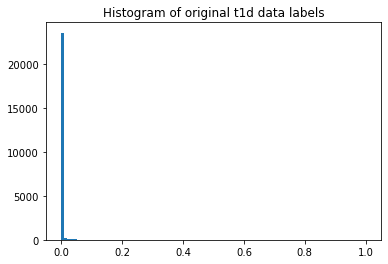

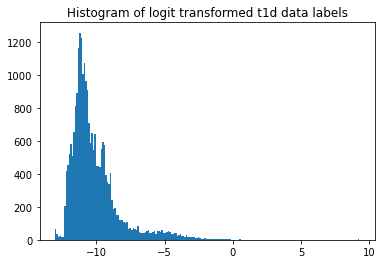

In [44]:
import matplotlib.pyplot as plt

def logit(p):
    return np.log(p / (1 - p))

_ = plt.hist(t1d_labels, bins=100)

plt.title("Histogram of original t1d data labels")
plt.show()

_ = plt.hist(t1d_labels.apply(lambda row: logit(row)), bins=200)

plt.title("Histogram of logit transformed t1d data labels")
plt.show()

# Feature Selection

## Correlation

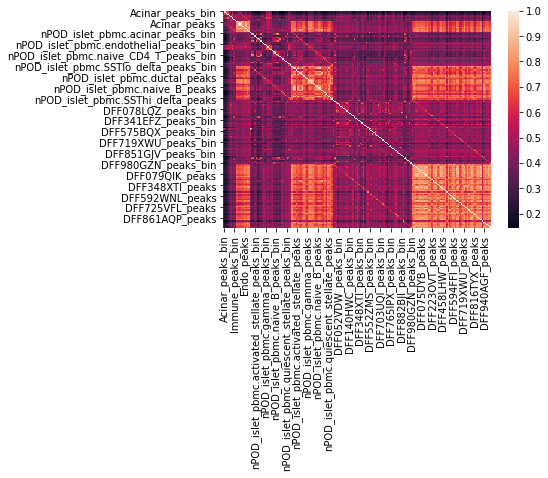

In [8]:
import seaborn as sns
corr = t1d_data.corr()
sns.heatmap(corr)

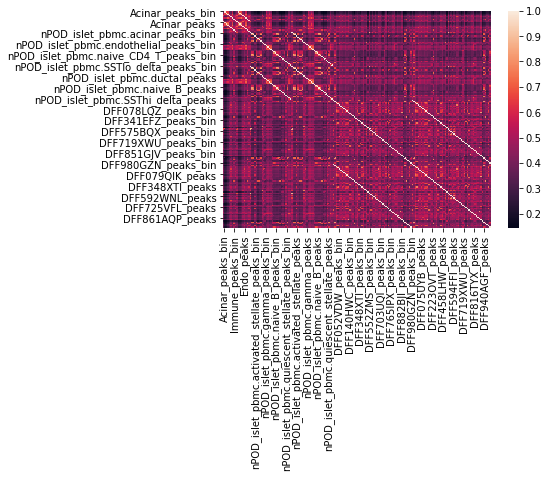

In [7]:
import seaborn as sns
corr = t1d_data.corr(method='spearman')
sns.heatmap(corr)

In [8]:
# Print which columns are too highly correlated
print("Columns that have correlation >= 90%")
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            print(t1d_data.columns[i], t1d_data.columns[j])
            if columns[j]:
                columns[j] = False

selected_columns = t1d_data.columns[columns]
t1d_data_selected = t1d_data[selected_columns]

Columns that have correlation >= 90%
Acinar_peaks_bin Acinar_peaks
Alpha_peaks_bin Alpha_peaks
Beta_peaks_bin Beta_peaks
Delta_peaks_bin Delta_peaks
Ductal_peaks_bin Ductal_peaks
Endo_peaks_bin Endo_peaks
Gamma_peaks_bin Gamma_peaks
Immune_peaks_bin Immune_peaks
Stellate_peaks_bin Stellate_peaks
nPOD_islet_pbmc.acinar_peaks_bin nPOD_islet_pbmc.acinar_peaks
nPOD_islet_pbmc.activated_CD4_T_peaks_bin nPOD_islet_pbmc.activated_CD4_T_peaks
nPOD_islet_pbmc.activated_CD8_T_peaks_bin nPOD_islet_pbmc.activated_CD8_T_peaks
nPOD_islet_pbmc.activated_stellate_peaks_bin nPOD_islet_pbmc.activated_stellate_peaks
nPOD_islet_pbmc.adaptive_NK_peaks_bin nPOD_islet_pbmc.adaptive_NK_peaks
nPOD_islet_pbmc.classical_monocyte_peaks_bin nPOD_islet_pbmc.classical_monocyte_peaks
nPOD_islet_pbmc.conventional_dendritic_peaks_bin nPOD_islet_pbmc.conventional_dendritic_peaks
nPOD_islet_pbmc.cytotoxic_NK_peaks_bin nPOD_islet_pbmc.cytotoxic_NK_peaks
nPOD_islet_pbmc.ductal_peaks_bin nPOD_islet_pbmc.ductal_peaks
nPOD_is

In [28]:
t1d_data_selected

,Acinar_peaks_bin,Alpha_peaks_bin,Beta_peaks_bin,Delta_peaks_bin,Ductal_peaks_bin,Endo_peaks_bin,Gamma_peaks_bin,Immune_peaks_bin,Stellate_peaks_bin,Acinar_peaks,...,DFF765IPX_peaks,DFF777KIG_peaks,DFF786BZB_peaks,DFF816TYX_peaks,DFF817FSM_peaks,DFF851GJV_peaks,DFF861AQP_peaks,DFF930SVS_peaks,DFF948XFT_peaks,DFF980GZN_peaks
0,0,0,0,0,0,0,0,0,0,0,...,0,0,92,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,1,160,...,0,0,300,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,1,160,...,0,0,300,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,1,160,...,0,0,300,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24135,0,1,1,1,1,0,1,1,0,0,...,0,0,0,123,0,0,0,0,0,0
24136,0,1,1,1,0,0,1,0,0,0,...,135,0,100,213,0,0,0,0,4246,0
24137,0,1,1,1,0,0,1,0,0,0,...,135,0,100,213,0,0,0,0,4246,0


In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# high_prob_thresholds = [0.01, 0.001, 0.0001]
# low_prob_thresholds = [0.000005, 0.000006, 0.000007, 0.000008, 0.00001]
high_prob_thresholds = [0.01]
low_prob_thresholds = [0.000005, 0.000006, 0.000007]
kernels = ['knn', 'rbf']
# gammas = [30, 25, 20, 15, 10, 5]
# gammas = [25, 20, 15]
gammas = [20]
# n_neighbors = [10, 9, 8, 7, 6, 5, 4]
# n_neighbors = [8, 7, 6]
n_neighbors = [8]
# alphas = [0.01, 0.2, 0.5, 0.8]
alphas = [0.2, 0.5]

res_columns = [
    "Positive Threshold",
    "Negative Threshold",
    "Num Positive Variants",
    "Num Negative Variants",
    "Num Unlabelled Variants",
    "Pos/Neg ratio",
    "Labelled/Unlabelled Ratio",
    "Kernel",
    "alpha",
    "gamma",
    "n_neighbors",
    "Average Accuracy Score"
]
res = pandas.DataFrame(columns=res_columns)

for prob_thresh_high in high_prob_thresholds:
    for prob_thresh_low in low_prob_thresholds:
        # Label points based on prob thresholds
        print("high: ", prob_thresh_high, "low", prob_thresh_low, end=':')
        print("Positive", len(t1d_labels[t1d_labels > prob_thresh_high]), end='; ')
        print("Negative", len(t1d_labels[t1d_labels < prob_thresh_low]), end='; ')
        print("Unlabelled", len(t1d_labels[(t1d_labels <= prob_thresh_high) & (t1d_labels >= prob_thresh_low)]), end='; ')
        print("")
        t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, prob_thresh_high, prob_thresh_low))
        
        # Data stats
        num_pos = len(t1d_labels_thresh[t1d_labels_thresh == 1])
        num_neg = len(t1d_labels_thresh[t1d_labels_thresh == 0])
        num_unlabelled = len(t1d_labels_thresh[t1d_labels_thresh == -1])
        pos_neg_ratio = num_pos / num_neg
        label_ratio = (num_pos + num_neg) / num_unlabelled
        
        alphas += [1 - prob_thresh_high]
        for alpha in alphas:
            for kernel in kernels:
                models = []
                if kernel == 'rbf':
                    for gamma in gammas:
                        model = LabelSpreading(kernel='rbf', alpha=alpha, gamma=gamma)
                        norm_model = make_pipeline(MinMaxScaler(), model)
                        score = perform_cv(norm_model, t1d_data_selected, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, gamma, "N/A", score]
                elif kernel == 'knn':
                    for neighbors in n_neighbors:
                        model = LabelSpreading(kernel="knn", alpha=alpha, n_neighbors=neighbors)
                        norm_model = make_pipeline(Normalizer(), model)
                        score = perform_cv(norm_model, t1d_data_selected, t1d_labels_thresh)
                        res.loc[res.shape[0]] = [prob_thresh_high, prob_thresh_low, num_pos, num_neg, num_unlabelled, pos_neg_ratio, label_ratio, kernel, alpha, "N/A", neighbors, score]

                else:
                    print("Error; invalid kernel")
                    continue

res.to_csv("./Results/label_spreading_res_feature_selection.csv")

high:  0.01 low 5e-06:Positive 589; Negative 533; Unlabelled 23017; 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_dis

high:  0.01 low 6e-06:Positive 589; Negative 1287; Unlabelled 22263; 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_dis

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.9min finished


high:  0.01 low 7e-06:Positive 589; Negative 2094; Unlabelled 21456; 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_dis

/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=30 was reached without convergence.
  category=ConvergenceWarning
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/opt/conda/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarn

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

class LogitRegression(LinearRegression):
    
    def __init__(self, n_jobs=1):
        super().__init__(n_jobs=n_jobs)

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

model = LogitRegression()
clf = make_pipeline(MinMaxScaler(), model)
clf2 = make_pipeline(Normalizer(), model)
clf3 = make_pipeline(StandardScaler(), model)

print("All features logit regression scores")

score = cross_val_score(clf, t1d_data, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))

score = cross_val_score(model, t1d_data, y=t1d_labels)
print("Logit Regression Score", np.mean(score))

score = cross_val_score(LinearRegression(), t1d_data, y=t1d_labels)
print("Linear regression Score:", np.mean(score))

print("Feature selection logit regression scores")

score = cross_val_score(clf, t1d_data_selected, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data_selected, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data_selected, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))

score = cross_val_score(model, t1d_data_selected, y=t1d_labels)
print("Logit Regression Score", np.mean(score))

score = cross_val_score(LinearRegression(), t1d_data_selected, y=t1d_labels)
print("Linear regression Score:", np.mean(score))

print("PCA logit regression scores")

score = cross_val_score(clf, t1d_data_pca, y=t1d_labels)
print("MinMaxScaler normalized Score:", np.mean(score))

score = cross_val_score(clf2, t1d_data_pca, y=t1d_labels)
print("Normalizer Score:", np.mean(score))

score = cross_val_score(clf3, t1d_data_pca, y=t1d_labels)
print("Standard Scaler Score:", np.mean(score))

score = cross_val_score(model, t1d_data_pca, y=t1d_labels)
print("Logit Regression Score", np.mean(score))

score = cross_val_score(LinearRegression(), t1d_data_pca, y=t1d_labels)
print("Linear regression Score:", np.mean(score))

All features logit regression scores
MinMaxScaler normalized Score: -0.007239737790892153
Normalizer Score: -0.007255656496357776
Standard Scaler Score: -0.007239737790892153
Logit Regression Score -0.007239737790891843
Linear regression Score: -0.011107550708212432
Feature selection logit regression scores
MinMaxScaler normalized Score: -0.0072371549794236325
Normalizer Score: -0.007254466935958215
Standard Scaler Score: -0.0072371549794236325
Logit Regression Score -0.007237154979423366
Linear regression Score: -0.008179155602516763
PCA logit regression scores
MinMaxScaler normalized Score: -0.007266871570055544
Normalizer Score: -0.007258299663771872
Standard Scaler Score: -0.007266871570055544
Logit Regression Score -0.007266871570055544
Linear regression Score: -0.0003680596078408538


# Printing extreme PC values

In [9]:
# Raw data from csv
t1d_data_raw = pandas.read_csv(t1d_mat, sep='\s+')

# Splitting labels and data
t1d_labels_raw = t1d_data_raw["Probability"]
t1d_var_data = t1d_data_raw['VarID']
t1d_data_raw = t1d_data_raw.drop(['VarID', 'Probability'], axis=1)

# Filtering out variants with all 0s
print("Originally", len(t1d_data_raw), "variants.", "Filtering out", len(t1d_data_raw) - len(t1d_data_raw[(t1d_data_raw.T != 0).any()]), "variants; left with", len(t1d_data_raw[(t1d_data_raw.T != 0).any()]))

t1d_data = t1d_data_raw[(t1d_data_raw.T != 0).any()]  # Only non-zero variants
t1d_labels = t1d_labels_raw[t1d_labels_raw.index.isin(t1d_data.index)]  # Get matching labels
t1d_var_idx = t1d_var_data[t1d_var_data.index.isin(t1d_data.index)]   # Get matching Variant IDs 

Originally 24139 variants. Filtering out 0 variants; left with 24139


In [10]:
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1d_data)

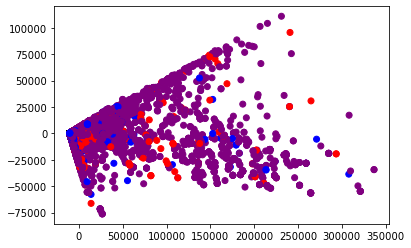

In [12]:
# Categorical labelling
def label_prob(prob, prob_threshold_high, prob_threshold_low):
    if prob > prob_threshold_high:
        return 1
    elif prob < prob_threshold_low:
        return 0
    else:
        return -1
    
t1d_labels_thresh = t1d_labels.apply(lambda row: label_prob(row, 0.01, 0.000007))

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
color_map = ['purple', 'red', 'blue']
colors = [color_map[t1d_labels_thresh[x] + 1] for x in range(len(t1d_labels_thresh.values))]
ax.scatter(new_data[:,0], new_data[:,1], color=colors)

# ax.set_xlabel("PC 1", size=15)
# ax.set_ylabel("PC 2", size=15)
# ax.set_xticklabels(ax.get_xticks(), size=12)
# ax.set_yticklabels(ax.get_yticks(), size=12)
# ax.spines["top"].set_visible(False);
# ax.spines["right"].set_visible(False);
# ax.get_xaxis().tick_bottom();
# ax.get_yaxis().tick_left();
t1d_PCS = t1d_data.copy(deep=True)
t1d_PCS.insert(0, "VarID", t1d_var_data)
t1d_PCS.insert(len(t1d_data.columns), "PC1", new_data[:,0])
t1d_PCS.insert(len(t1d_PCS.columns), "PC2", new_data[:,1])
t1d_PCS.sort_values('PC1', ascending=False)[:10].to_csv('Results/top_10_PC1_vals_varIDs.csv')
t1d_less_than_100 = t1d_PCS[t1d_PCS.PC1 <= 100]
t1d_less_than_100[t1d_less_than_100.PC1 >= 0].sort_values('PC1')[:10].to_csv('Results/top_10_PC1_vals_varIDs.csv', mode='a')

In [ ]:
t1d_less_than_100 = t1d_PCS[t1d_PCS.PC1 <= 100]
t1d_less_than_100[t1d_less_than_100.PC1 >= 0].sort_values('PC1')[:10].to_csv('Results/top_10_PC1_vals.csv', mode='a')